# **PREDICCIÓN DE SUPERVIVENCIA: PACIENTES EN UCI**
_Por Nicole Lastra Quiroz - Junio 2022_

## Objetivo del proyecto

Crear un árbol de decisión que permita predecir la supervivencia de pacientes en la Unidad de Cuidados Intensivos (UCI), según sus signos vitales, enfermedades crónicas, comorbilidades, etc.

<img src='https://www.gruporecoletas.com/noticias/wp-content/uploads/2019/09/Que-es-UCI-Unidad-Cuidados-Intensivos-Recoletas-1280x720.jpg' style='float:center ; padding:16px'/>

## Importación de librerías

In [1]:
# Importación de librerías:

# Para tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Para gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

# Para preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder

# Para configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importación de los datos

El código a continuación, va a funcionar únicamente si se tiene el archivo `Dataset.csv` en la misma carpeta local en que se almacena el archivo de este trabajo. 

Si se está revisando desde Colab u otra plataforma online, primero se debe cargar el archivo `Dataset.csv` en la sección de carga de documentos correspondiente (en Colab aparece la opción al _'clickear'_ en el símbolo de _'carpeta'_ que hay en el costado izquierdo de la pantalla).

In [2]:
# Importación de datos:
# ------------------------------------------------------------------------------
df = pd.read_csv('Dataset.csv')  

## Visualización de los datos

Como son tantos datos (según información entregada previa al trabajo), procederemos a visualizar un número más grande de lo usual (150 filas), e intentar de identificar, a simple vista primero, alguna anormalidad o característica especial.

Notar que en este caso se elimina la restricción de mostrar columnas y filas, de modo que lo observado sea la totalidad de datos en estas 150 filas.

In [3]:
# Eliminación de restricción del máximo de columnas y filas mostrado
# ------------------------------------------------------------------------------
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Revisión de 150 filas de datos 
# ------------------------------------------------------------------------------
df.head(150)


encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0           66154       25312          118               0  68.0  22.730000   
1          114252       59342           81               0  77.0  27.420000   
2          119783       50777          118               0  25.0  31.950000   
3           79267       46918          118               0  81.0  22.640000   
4           92056       34377           33               0  19.0        NaN   
5           33181       74489           83               0  67.0  27.560000   
6           82208       49526           83               0  59.0  57.450000   
7          120995       50129           33               0  70.0        NaN   
8           80471       10577          118               1  45.0        NaN   
9           42871       90749          118               0  50.0  25.710000   
10         105427      125898           77               0  72.0  28.257052   
11          91609       78266           83               0  80.0  27.382812   
12          76356       41311          118               0  48.0        NaN   
13          34030      103766          118               0  65.0        NaN   
14         108388       98174          118               0  81.0  38.189067   
15         120677      124688          118               0  78.0        NaN   
16         115771       71252           81               0  30.0  23.383178   
17          22471      112115          118               0  46.0  25.845717   
18          48056      114220          118               0  65.0  28.408929   
19          45954      102946          118               0  39.0  37.010278   
20          79115       88295           83               0  79.0  28.376100   
21         118620       59115          118               0  80.0  35.659989   
22          21050       31257           81               0  58.0        NaN   
23          95460      120539          118               0  87.0  21.963763   
24           7220       92453           77               0  60.0  29.509959   
25          29208      114628          118               1  68.0  26.010703   
26          32902       17922          118               0  85.0  23.809770   
27          16847        8036           33               0  79.0  23.408979   
28          46026       71020          118               0   NaN        NaN   
29           6777       83373          118               0  60.0  26.485715   
30         129675       45336           77               0  76.0  32.374349   
31           6603       17124           83               0  68.0  27.560503   
32         123939       65066           77               0  30.0  17.003550   
33          48566       94258          118               0  45.0  32.129842   
34         112789       74366           81               0  53.0  23.626083   
35          81252       88655          118               0  71.0  38.497016   
36         114022       66780          118               0  71.0  34.305694   
37          18207      130642          149               0  58.0        NaN   
38          59698       79638          118               0  85.0  21.889645   
39          92404       93844          118               0  65.0  26.286417   
40          83698       14184          149               0  82.0  23.738117   
41          44512       36199           77               0  60.0        NaN   
42          90015       66420           33               0  87.0  18.745276   
43          31303        2406           31               0  52.0  23.039099   
44          71147       52594          118               0  60.0  35.452865   
45          77034       42887           83               0  75.0  33.480398   
46          40903       55564          118               1  64.0  16.980389   
47          73237        1755          151               0  59.0  14.844926   
48          61230       53787          118               0  55.0  32.205360   
49         115636         453           69             

Inicialmente se observa que hay varios datos `NaN` (o nulos). Además, en la última columna (`apache_2_bodysystem`), existen dos formas de redacción para un mismo dato: _'Undefined Diagnosis'_ y _'Undefined diagnoses'_. 

Se debe tener en cuenta que ambas situaciones se tendrán que corregir en la etapas futuras para un óptimo procesamiento de los datos.


In [4]:
# Revisión general de los datos
# ------------------------------------------------------------------------------
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    encounter_id                   int64  
 1    patient_id                     int64  
 2    hospital_id                    int64  
 3    hospital_death                 int64  
 4    age                            float64
 5    bmi                            float64
 6    elective_surgery               int64  
 7    ethnicity                      object 
 8    gender                         object 
 9    height                         float64
 10   hospital_admit_source          object 
 11   icu_admit_source               object 
 12   icu_id                         int64  
 13   icu_stay_type                  object 
 14   icu_type                       object 
 15   pre_icu_los_days               float64
 16   readmission_status             int64  
 17   weight                       

El data frame `df` tiene 170 columnas con datos tipo `float64`, 8 del tipo `int64` y 8 del tipo `object`, haciendo un total de 186 columnas y 91.713 filas de datos.

##### **Gráficas relevantes**

A continuación se revisarán algunas gráficas que pueden presentar información interesante, en etapas tempranas de este estudio.

###### Gráficos de barra

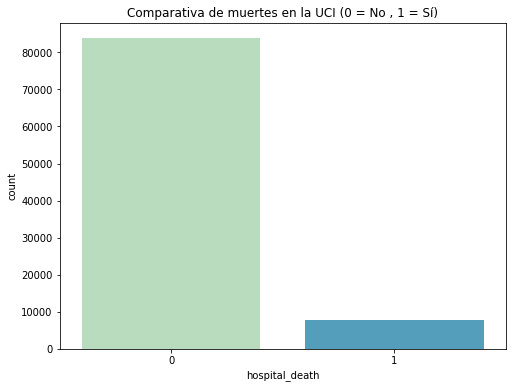

Número total de sobrevivientes : 83798
Número total de muertos : 7915


In [5]:
# Gráfico de barras dada la columna 'hospital_death'
# ------------------------------------------------------------------------------
fig , ax = plt.subplots(figsize=(8,6))

sns.countplot(x        = 'hospital_death', 
              data     = df,
              palette  = 'GnBu'
              )

plt.title('Comparativa de muertes en la UCI (0 = No , 1 = Sí)')
plt.show()

s0=len(df[df['hospital_death']==0])
s1=len(df[df['hospital_death']==1])

# Mostrar el numero total de muertos y sobrevivientes
# ------------------------------------------------------------------------------
print('Número total de sobrevivientes :' , s0)
print('Número total de muertos :', s1)

Principales hallazgos:

- Del total de pacientes, la mayor cantidad de ellos sobrevivió.
- En concreto, aróximadamente el 91.4% de los pacientes sobrevivieron a su estadía en el hospital, mientras que un 8.6% no lo logró.

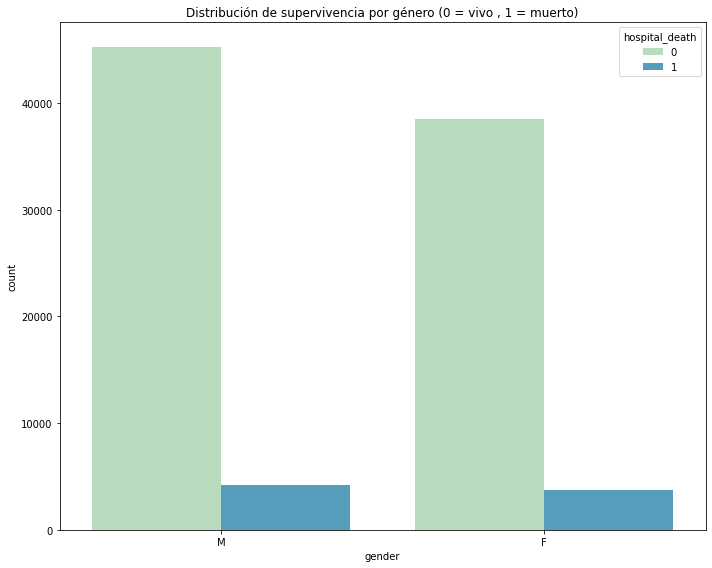

In [6]:
# Gráfico de barras segun 'gender' dado 'hospital_death'
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(10, 8))

sns.countplot(x        = 'gender',
             data     = df, 
             hue      = 'hospital_death',
             palette  = 'GnBu'
              )

plt.title('Distribución de supervivencia por género (0 = vivo , 1 = muerto)')
plt.tight_layout()
plt.show()

Principales hallazgos:

- Hay un mayor número de pacientes masculinos que femeninos (Hablando desde el modelo binario presentado).
- La distribución entre vivos y muertos es bastante cercana entre ambos grupos. No se podría hablar de números viendo sólo la gráfica, por lo que se requieren mayores análisis.

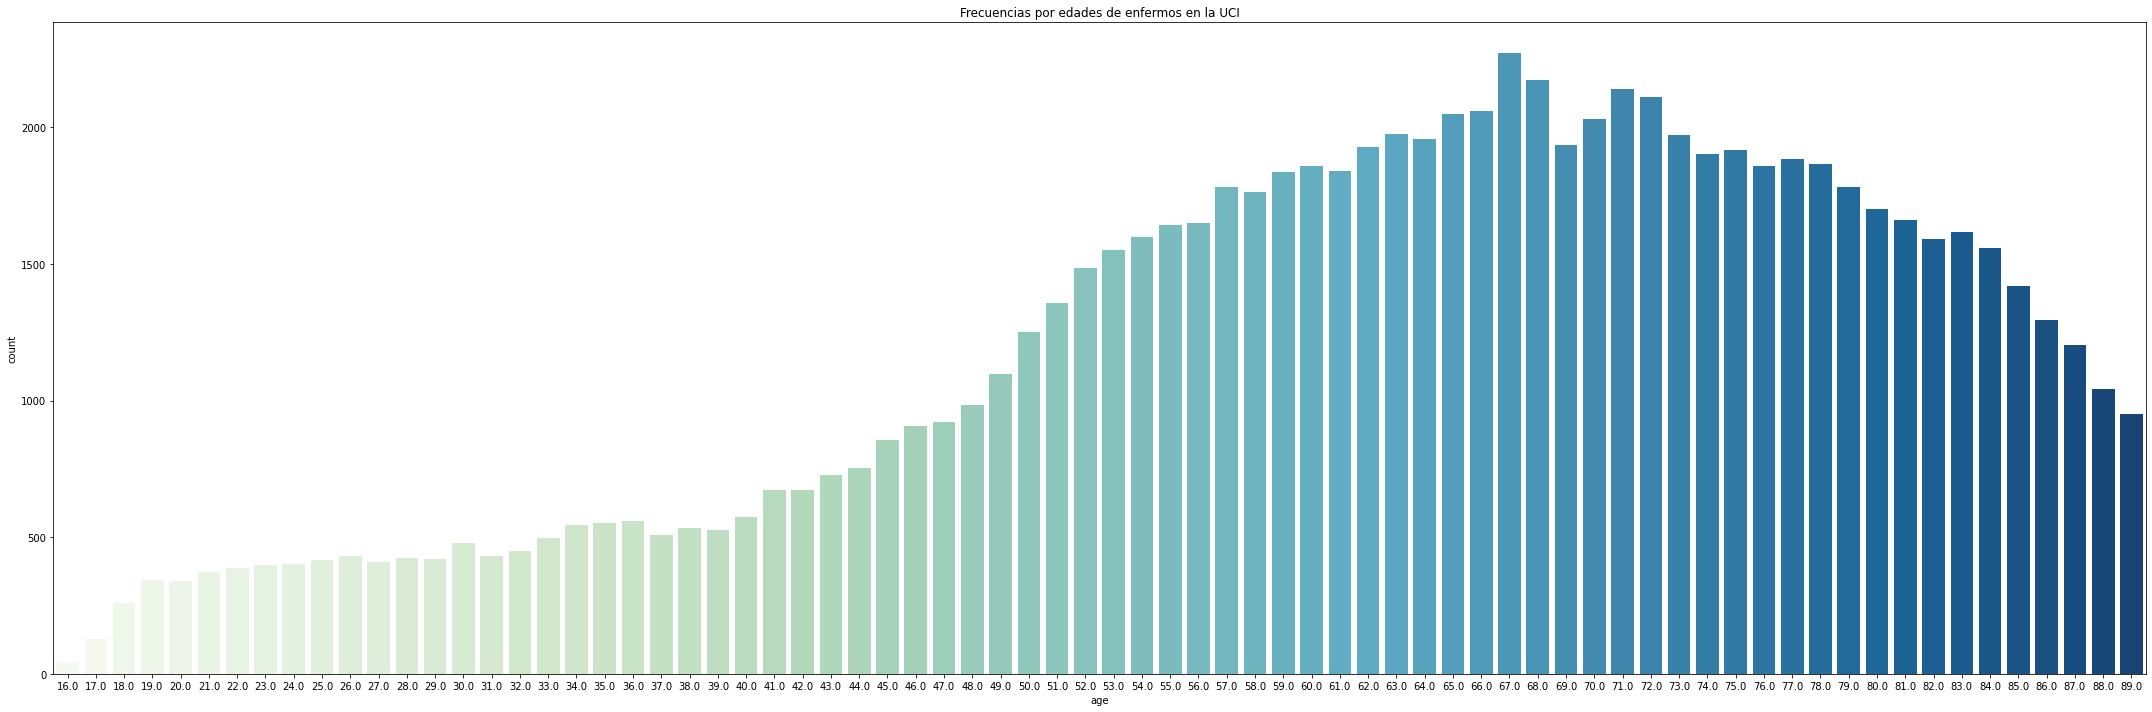

In [7]:
# Gráfico de barras dada la columna hospital_death
# ------------------------------------------------------------------------------
fig , ax = plt.subplots(figsize = (30,10))

sns.countplot(x       = 'age', 
              data    = df,
              palette = 'GnBu',
              )

plt.title('Frecuencias por edades de enfermos en la UCI')
plt.tight_layout()
plt.show()



Principales hallazgos:

- El rango etario va desde los 16 años, a los 89.
- La mayor frecuencia se obtiene con pacientes de 67 años, mientras que la menor, con pacientes de 16.
- Los datos presentan una distribución inclinada a la derecha.

###### Histograma

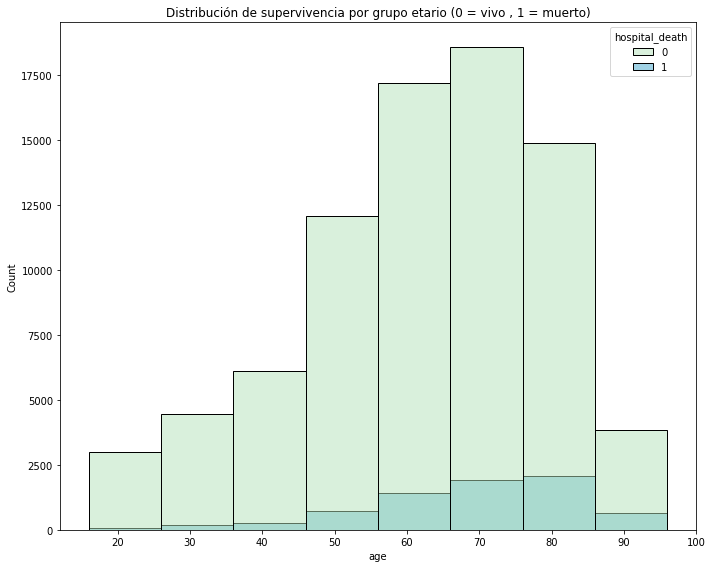

In [8]:
# Gráfico de barras segun 'age' dado 'hospital_death'
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(10, 8))

sns.histplot(x        = 'age',
             data     = df, 
             hue      = 'hospital_death',
             binwidth = 10,
             palette  = 'GnBu'
              )

plt.title('Distribución de supervivencia por grupo etario (0 = vivo , 1 = muerto)')
plt.tight_layout()
plt.show()

Principales hallazgos:

- Hasta los 76 años, ambas distribuciones parecen mantener una igualdad.
- En el rango de los 76 en adelante, se observa una evidente diferencia en la distribución de vivos y muertos.
- Muy en general, se puede decir que a mayor edad, mayor número de muertos (recordar que el último trozo del histograma corresponde de los 86 a los 96 años, sin embargo, el máximo de edad de los pacientes es de 88 años, por lo que aquel sector no es representativo del general de los datos, también se puede pensar que como se dan más muertes en segmentos cercanos a aquel, ya no hay pacientes que mueran a dicha edad, básicamente porque ya están muertos...)

###### Mapa de calor

A continuación graficaremos un mapa de calor para las variables numéricas.

- _Recuerda que puedes hacer click sobre las gráficas generadas, para verlas con mayor detalle._

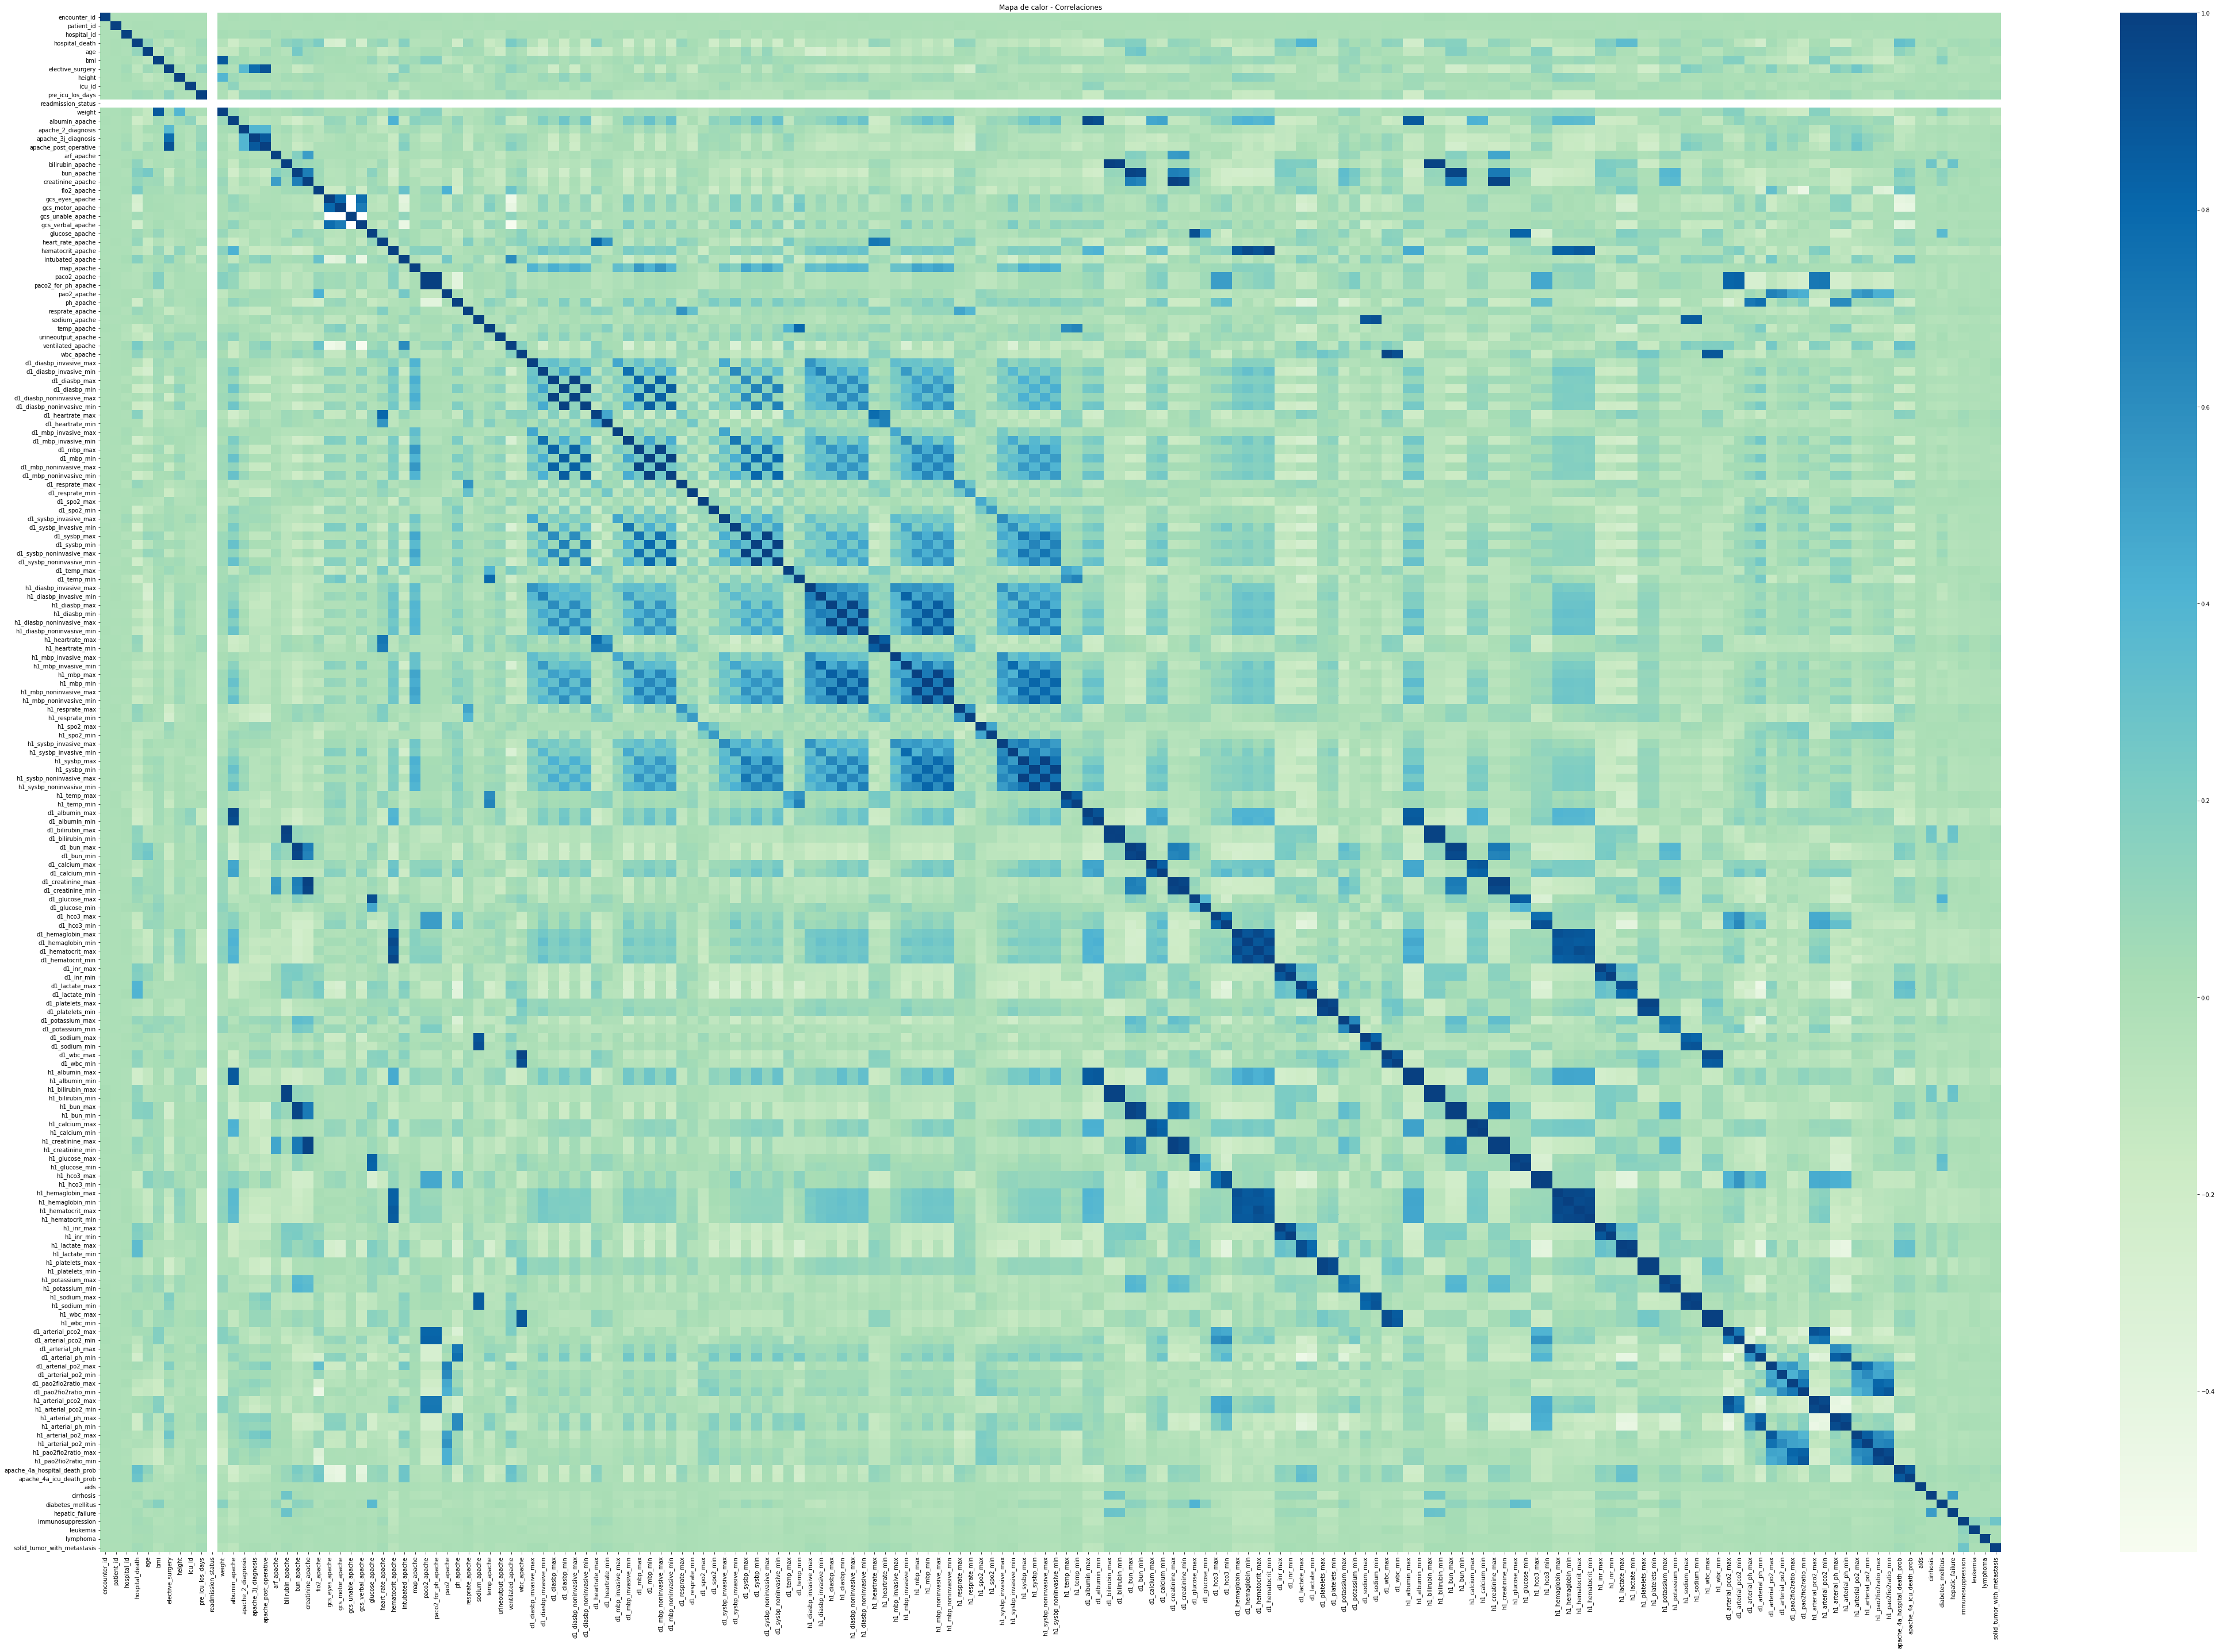

In [9]:
# Mapa de Calor para datos numéricos
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(60, 40))

sns.heatmap(df.corr(), 
            ax    = ax,
            cmap  = 'GnBu'
            )
plt.title('Mapa de calor - Correlaciones')
plt.tight_layout()
plt.show()

Principales hallazgos:

- Inmediatamente destacan las líneas blancas que corresponden a `readmission_status`, lo que sugiere que no hay aporte alguno de parte de sus datos (al revisar las tablas anteriores, podemos ver que sólo estaba compuesta por ceros). Se debe tener en cuenta en etapas futuras para revisión y posible eliminación de la columna.
- En general, existe más de una zona del mapa que presenta pequeños cúmulos de color rojizo, por lo que se evidencia desde el mapa ciertas zonas de correlación. Esto no es extraño, ya que hay que recordar que se está trabajando con datos médicos, y que muchas mediciones tienen que ver directamente con otras. Además, en este caso hay mediciones que directamente se repiten, bajo sistema d1 o h1, lo que implica, en el general de los casos, que tendrán algún grado alto de correlación.
- Puede ser un tanto confuso el mapa de calor para revisar particularidades, pero sirve para ver casos extremos e identificar en fase inicial las posibles relaciones entre variables (como un todo).

###### Diagramas de caja y bigotes

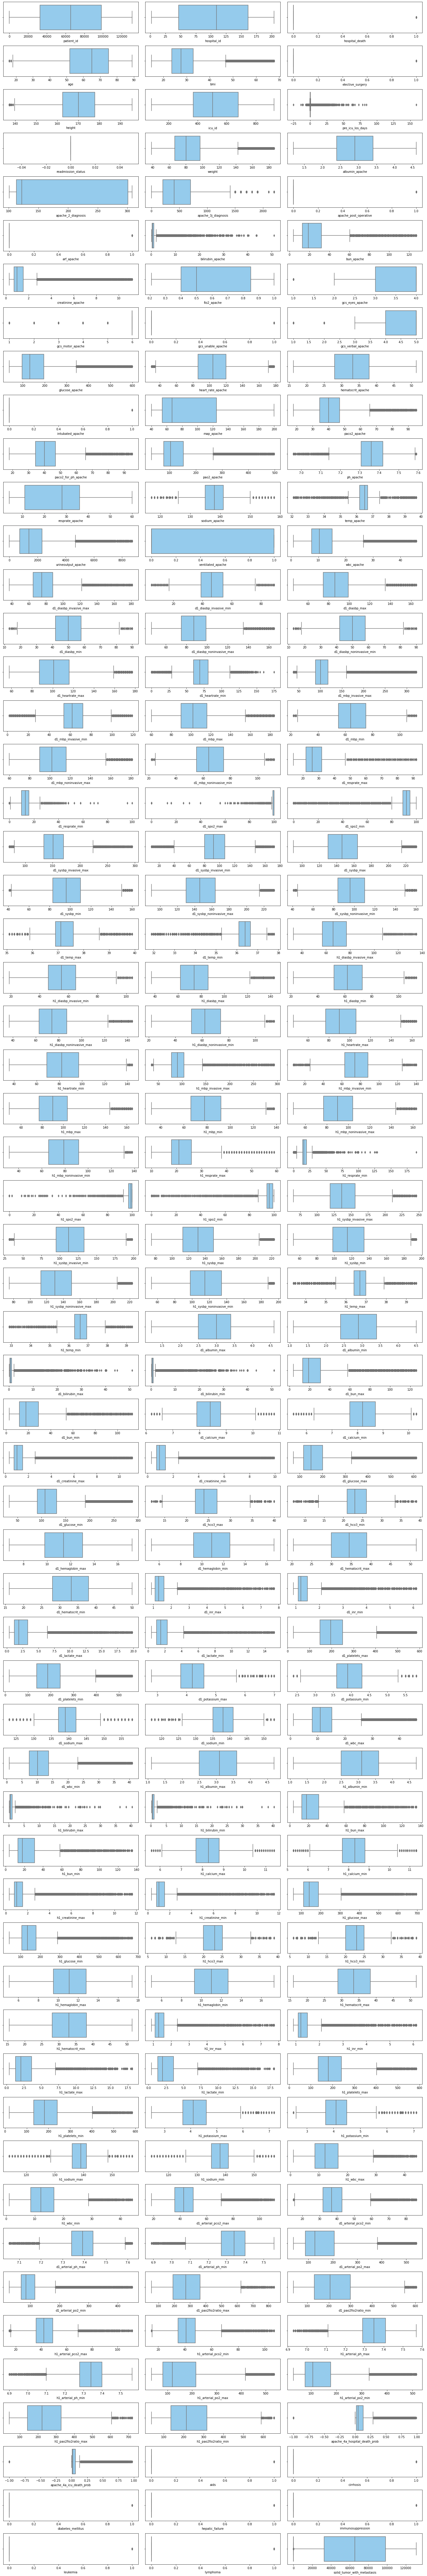

In [68]:
# Boxplots para cada columna numérica
# ------------------------------------------------------------------------------
num   = df._get_numeric_data()
names = list(num.columns)
f, axes = plt.subplots(round(len(names)/3), 3, figsize = (20, 120))  
y = 0;
for name in names:
    i, j = divmod((y-1), 3)
    sns.boxplot(
        x     = num[name], 
        ax    = axes[i, j],
        color  = 'lightskyblue'
        )
    
    y = y + 1
plt.tight_layout()
plt.show()

Principales hallazgos:

- Sólo se observan unas pocas distribuciones sin datos atípicos. Esto podría hacer pensar que existen muchos datos erróneos o que no podrían existir, pero se de debe tener en cuenta el contexto nuevamente: "información, exámenes y otras mediciones de pacientes", por tanto no podemos descartar que exista alguien con una glucosa por sobre los 400 de indicador, ya que podría tener dichos valores precisamente por una condición médica que lo hace estar en el hospital, o bien por una condición crónica, por ello es que no es tan simple aplicar Data Science a los datos, siempre se deben considerar los contextos (un estudio más específico requeriría de un par experto que revise o valide las acciones del Data Scientist).
- También se observan escasos boxplots con distribuciones más o menos uniformes (como el caso de todos los ligados a mediciones de albumia, a modo de ejemplo).
-`readmission_status` definitivamente está compuesta sólo por ceros, por tanto no aporta un valor relevante (no caer en pensar que no hubo readmisiones de pacientes, para esto es conveniente tener cerca el diccionario de los datos y contrastar con su significado específico).
- Variables del tipo `Id` no aportan mayor información ya que hacen referencia a datos diferentes entre sí (salvo la referencia a hospitales, ya que cada número representa un hospital y podríamos encontrar alguna relación entre ir a un hospital u otro, o no... pero no se podría descartar aún).


### **Hallazgos y concluciones de la etapa**

Las visualizaciones variadas pueden ayudar a enrriquecer los estudios sobre datos, ya que dan una idea básica, incluso sin saber mucho del área de donde provienen los datos, previo a estudios y/o procesamientos mayores. 

En este caso, además de obtener una idea general del comportamiento de los datos, encontramos varias particularidades que ayudarán a agilizar el proceso de limpieza y extracción de datos.

## Extracción y limpieza de datos

### **Datos erróneos**

Comenzaremos eliminando las columnas `encounter_id` y `patient_id` ya que son identificadores únicos y específicos de cada caso, lo que no nos entrega algún tipo de información al grupo (como se había mencionado en la etapa anterior). Sí dejaremos la columna`hospital_id` ya que no se puede descartar del todo, una correlación entre muertos y el hospital al que ingresan. 

En el caso de `readmission_status`, se eliminará la columna completa ya que, como observamos del mapa de calor y de los boxplots, sus datos corresponden únicamente a ceros y no generan mayor aporte de informción.

In [22]:
df1 = df.drop(['encounter_id','patient_id','readmission_status'], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 183 entries, hospital_id to apache_2_bodysystem
dtypes: float64(170), int64(5), object(8)
memory usage: 128.0+ MB


En las visualizaciones iniciales también notamos lo que ocurría con la columna `apache_2_bodysystem`, por lo que ahora aunaremos el criterio erróneamente escrito de dos formas distintas, como _'Undefined'_.

In [23]:
# Unificación de criterio 'Undefined' para diagnóstico no definido en columna 'apache_2_bodysystem'

df1['apache_2_bodysystem'] = df1['apache_2_bodysystem'].replace(['Undefined Diagnoses','Undefined diagnoses'], 'Undefined')
df.head(150)

encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0           66154       25312          118               0  68.0  22.730000   
1          114252       59342           81               0  77.0  27.420000   
2          119783       50777          118               0  25.0  31.950000   
3           79267       46918          118               0  81.0  22.640000   
4           92056       34377           33               0  19.0        NaN   
5           33181       74489           83               0  67.0  27.560000   
6           82208       49526           83               0  59.0  57.450000   
7          120995       50129           33               0  70.0        NaN   
8           80471       10577          118               1  45.0        NaN   
9           42871       90749          118               0  50.0  25.710000   
10         105427      125898           77               0  72.0  28.257052   
11          91609       78266           83               0  80.0  27.382812   
12          76356       41311          118               0  48.0        NaN   
13          34030      103766          118               0  65.0        NaN   
14         108388       98174          118               0  81.0  38.189067   
15         120677      124688          118               0  78.0        NaN   
16         115771       71252           81               0  30.0  23.383178   
17          22471      112115          118               0  46.0  25.845717   
18          48056      114220          118               0  65.0  28.408929   
19          45954      102946          118               0  39.0  37.010278   
20          79115       88295           83               0  79.0  28.376100   
21         118620       59115          118               0  80.0  35.659989   
22          21050       31257           81               0  58.0        NaN   
23          95460      120539          118               0  87.0  21.963763   
24           7220       92453           77               0  60.0  29.509959   
25          29208      114628          118               1  68.0  26.010703   
26          32902       17922          118               0  85.0  23.809770   
27          16847        8036           33               0  79.0  23.408979   
28          46026       71020          118               0   NaN        NaN   
29           6777       83373          118               0  60.0  26.485715   
30         129675       45336           77               0  76.0  32.374349   
31           6603       17124           83               0  68.0  27.560503   
32         123939       65066           77               0  30.0  17.003550   
33          48566       94258          118               0  45.0  32.129842   
34         112789       74366           81               0  53.0  23.626083   
35          81252       88655          118               0  71.0  38.497016   
36         114022       66780          118               0  71.0  34.305694   
37          18207      130642          149               0  58.0        NaN   
38          59698       79638          118               0  85.0  21.889645   
39          92404       93844          118               0  65.0  26.286417   
40          83698       14184          149               0  82.0  23.738117   
41          44512       36199           77               0  60.0        NaN   
42          90015       66420           33               0  87.0  18.745276   
43          31303        2406           31               0  52.0  23.039099   
44          71147       52594          118               0  60.0  35.452865   
45          77034       42887           83               0  75.0  33.480398   
46          40903       55564          118               1  64.0  16.980389   
47          73237        1755          151               0  59.0  14.844926   
48          61230       53787          118               0  55.0  32.205360   
49         115636         453           69             

Ahora se puede ver que, por ejemplo, en la fila 88 de la columna `apache_2_bodysystem`, aparece el registro _'Undefined'_.


### **Creación de variables Dummy**

En este paso transformamos las 8 filas que hacen referencia a objetos / categorías nominales, mediante el uso de variables dummies, así trabajaremos sólo con números y podremos generar el árbol sin recurrir a un _hot-encoder_.

In [24]:
# Generación de variables dummy para las categorías 'object' y eliminación de 
# originales para evitar duplicado de la misma información 
# ------------------------------------------------------------------------------
df2 = pd.get_dummies(data = df1, drop_first=True)

# Eliminación de restricción del máximo de columnas
# ------------------------------------------------------------------------------
pd.options.display.max_columns = None

# Revisión de datos
# ------------------------------------------------------------------------------ 
df2.head()

hospital_id  hospital_death   age    bmi  elective_surgery  height  icu_id  \
0          118               0  68.0  22.73                 0   180.3      92   
1           81               0  77.0  27.42                 0   160.0      90   
2          118               0  25.0  31.95                 0   172.7      93   
3          118               0  81.0  22.64                 1   165.1      92   
4           33               0  19.0    NaN                 0   188.0      91   

   pre_icu_los_days  weight  albumin_apache  apache_2_diagnosis  \
0          0.541667    73.9             2.3               113.0   
1          0.927778    70.2             NaN               108.0   
2          0.000694    95.3             NaN               122.0   
3          0.000694    61.7             NaN               203.0   
4          0.073611     NaN             NaN               119.0   

   apache_3j_diagnosis  apache_post_operative  arf_apache  bilirubin_apache  \
0               502.01                      0         0.0               0.4   
1               203.01                      0         0.0               NaN   
2               703.03                      0         0.0               NaN   
3              1206.03                      1         0.0               NaN   
4               601.01                      0         0.0               NaN   

   bun_apache  creatinine_apache  fio2_apache  gcs_eyes_apache  \
0        31.0               2.51          NaN              3.0   
1         9.0               0.56          1.0              1.0   
2         NaN                NaN          NaN              3.0   
3         NaN                NaN          0.6              4.0   
4         NaN                NaN          NaN              NaN   

   gcs_motor_apache  gcs_unable_apache  gcs_verbal_apache  glucose_apache  \
0               6.0                0.0                4.0           168.0   
1               3.0                0.0                1.0           145.0   
2               6.0                0.0                5.0             NaN   
3               6.0                0.0                5.0           185.0   
4               NaN                NaN                NaN             NaN   

   heart_rate_apache  hematocrit_apache  intubated_apache  map_apache  \
0              118.0               27.4               0.0        40.0   
1              120.0               36.9               0.0        46.0   
2              102.0                NaN               0.0        68.0   
3              114.0               25.9               1.0        60.0   
4               60.0                NaN               0.0       103.0   

   paco2_apache  paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  \
0           NaN                  NaN          NaN        NaN             36.0   
1          37.0                 37.0         51.0       7.45             33.0   
2           NaN                  NaN          NaN        NaN             37.0   
3          30.0                 30.0        142.0       7.39              4.0   
4           NaN                  NaN          NaN        NaN             16.0   

   sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  \
0          134.0         39.3                 NaN                0.0   
1          145.0         35.1                 NaN                1.0   
2            NaN         36.7                 NaN                0.0   
3            NaN         34.8                 NaN                1.0   
4            NaN         36.7                 NaN                0.0   

   wbc_apache  d1_diasbp_invasive_max  d1_diasbp_invasive_min  d1_diasbp_max  \
0        14.1                    46.0                    32.0           68.0   
1        12.7                     NaN                     NaN           95.0   
2         NaN                     NaN                     NaN           88.0   
3         8.0                    62.0                    30.0           48.0   
4         NaN      

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 226 entries, hospital_id to apache_2_bodysystem_Undefined
dtypes: float64(170), int64(5), uint8(51)
memory usage: 126.9 MB


Observamos que ahora ya no existen variables tipo `object`.

### **Revisión de datos faltantes**

Ahora prestamos atención a los valores NaN. 

Comenzaremos revisando la suma total de ellos por columna, para tener una referencia del tipo de  limpieza a aplicar, por ejemplo: 
- Eliminación de filas, según el número de columnas con _NaN values_
- Eliminación de columnas, que tengan un alto porcentaje de _NaN values_.

O bien si se puede realizar algún llenado de datos por medio de la moda, la media o la mediana, según corresponda.


In [26]:
# Eliminación de restricción del máximo de filas
# ------------------------------------------------------------------------------
pd.options.display.max_rows = None

# Conteo de valores NaN (ausentes) por columna
# ------------------------------------------------------------------------------
df2.isna().sum()

hospital_id                                       0
hospital_death                                    0
age                                            4228
bmi                                            3429
elective_surgery                                  0
height                                         1334
icu_id                                            0
pre_icu_los_days                                  0
weight                                         2720
albumin_apache                                54379
apache_2_diagnosis                             1662
apache_3j_diagnosis                            1101
apache_post_operative                             0
arf_apache                                      715
bilirubin_apache                              58134
bun_apache                                    19262
creatinine_apache                             18853
fio2_apache                                   70868
gcs_eyes_apache                                1901
gcs_motor_ap

Se observa que son demasiadas las columnas con NaN, lo que impide aplicar directamente un `df.dropna()` ya que estaríamos perdiendo gran parte de los datos (nos quedaríamos con menos de 30 _'pacientes'_, de los más de 91000 representados en el dataset).

En estricto rigor, según el profesor Balaraman Ravindran (Professor of Computer Science, Indian Institute of Technology Madras), cuando debemos descartar columnas por ausencia de datos, estas deben tener un 80% o más de `NaN` para ser eliminadas sin mayor consideración (aunque siempre se debe ver el contexto y la finalidad del estudio), en este caso, implicaría mantener columnas que tengan al menos 18.342 datos válidos... El problema de esto es que como ya apreciamos en los boxplots (y que confirmaremos en el paso que sigue), la mayoría de las columnas de datos no podrán tener refill ni por media, moda o mediana, ya que tienen muchos valores atípicos, y precisamente podríamos estar asignando un dato de una persona "sana" a una que por ejemplo falleció y no posee dicha medición simplemente por que no se realizó (es decir no podemos a ciegas y sin mayor expertiz en el área simplemente hacer éstos refills).

Resumiendo, en este caso, considerando el contexto de los datos, se utilizará como barrera de corte, el 50% aproximadamente. Esto implica que vamos a mantener columnas que tienen a lo menos 45857 datos.

In [27]:
# Eliminación de restricción del máximo de filas
# ------------------------------------------------------------------------------
pd.options.display.max_rows = None

# Se eliminan columnas con datos NaN > al 50% 
# es decir, se mantienen columnas con al menos 45857 datos válidos
# ------------------------------------------------------------------------------
df3 = df2.dropna(axis = 1, thresh = 45856)
# *** Tresh hace referencia a los datos restantes

df3 = df3.drop(['h1_temp_max','h1_temp_min'], axis=1)

# Conteo de valores NaN (ausentes) por columna again
# ------------------------------------------------------------------------------
df3.isna().sum()

hospital_id                                       0
hospital_death                                    0
age                                            4228
bmi                                            3429
elective_surgery                                  0
height                                         1334
icu_id                                            0
pre_icu_los_days                                  0
weight                                         2720
apache_2_diagnosis                             1662
apache_3j_diagnosis                            1101
apache_post_operative                             0
arf_apache                                      715
bun_apache                                    19262
creatinine_apache                             18853
gcs_eyes_apache                                1901
gcs_motor_apache                               1901
gcs_unable_apache                              1037
gcs_verbal_apache                              1901
glucose_apac

Luego de la eliminación de columnas, observamos que sigue habiendo número considerables de datos ausentes, por lo que en etapas posteriores deberemos decidir cómo proceder con ellos.

### **Variabilidad de datos por columnas y datos fuera de rango**

A continuación revisaremos los datos que ya visualizamos como boxplots anteriormente (recordar que ya no están todas las columnas presentes). 

In [28]:
print(df3.describe())

        hospital_id  hospital_death           age           bmi  \
count  91713.000000    91713.000000  87485.000000  88284.000000   
mean     105.669262        0.086302     62.309516     29.185818   
std       62.854406        0.280811     16.775119      8.275142   
min        2.000000        0.000000     16.000000     14.844926   
25%       47.000000        0.000000     52.000000     23.641975   
50%      109.000000        0.000000     65.000000     27.654655   
75%      161.000000        0.000000     75.000000     32.930206   
max      204.000000        1.000000     89.000000     67.814990   

       elective_surgery        height        icu_id  pre_icu_los_days  \
count      91713.000000  90379.000000  91713.000000      91713.000000   
mean           0.183736    169.641588    508.357692          0.835766   
std            0.387271     10.795378    228.989661          2.487756   
min            0.000000    137.200000     82.000000        -24.947222   
25%            0.000000    162.

Principales hallazgos:

- En el caso de `age` la media corresponde a poco más de 62 años, mientras que el segundo cuartil corresponde a 65 años. Viendo esto, y considerando los datos atípicos que en este caso podrían estar afectando ligeramente, se considera factible llenar la columna con el cuartil 2 (mediana).
- Las variables `d1_hemaglobin_max`, `d1_hemaglobin_min`, `d1_hematocrit_max` y `d1_hematocrit_min`, presentan medias y medianas aproximadamente iguales, con distribuciones bastante simétricas, por lo que se considera llenarlas con su respectiva media.

A continuación se procede con el llenado en acuerdo a lo comentado.

In [29]:
# Datos de las columnas
# ------------------------------------------------------------------------------
mediana_age = 65.0
m_d1_hemaglobin_max = 11.4
m_d1_hemaglobin_min = 10.9
m_d1_hematocrit_max = 34.5
m_d1_hematocrit_min = 33

# Llenado de las columnas
# ------------------------------------------------------------------------------
df3['age'] = df3['age'].fillna(mediana_age)
df3['d1_hemaglobin_max'] = df3['d1_hemaglobin_max'].fillna(m_d1_hemaglobin_max)
df3['d1_hemaglobin_min'] = df3['d1_hemaglobin_min'].fillna(m_d1_hemaglobin_min)
df3['d1_hematocrit_max'] = df3['d1_hematocrit_max'].fillna(m_d1_hematocrit_max)
df3['d1_hematocrit_min'] = df3['d1_hematocrit_min'].fillna(m_d1_hematocrit_min)


df3.isna().sum()

hospital_id                                       0
hospital_death                                    0
age                                               0
bmi                                            3429
elective_surgery                                  0
height                                         1334
icu_id                                            0
pre_icu_los_days                                  0
weight                                         2720
apache_2_diagnosis                             1662
apache_3j_diagnosis                            1101
apache_post_operative                             0
arf_apache                                      715
bun_apache                                    19262
creatinine_apache                             18853
gcs_eyes_apache                                1901
gcs_motor_apache                               1901
gcs_unable_apache                              1037
gcs_verbal_apache                              1901
glucose_apac

Luego de revisar finalmente los números, se observa que aún hay datos faltantes en ciertas columnas. Si bien siempre se intenta mantener todos los datos posibles, de acuerdo a lo fundamentado en pasos anteriores, considerando el contexto de los datos y la ausencia de un par experto, se procederá a eliminar las filas con datos `NaN` (tal como se procedió en ejercitaciones en clase para efectos de simplificación del ejercicio al no ser el foco de este curso la limpieza y extracción de datos).

In [30]:
# Eliminación de rows con valores NaN 
# ------------------------------------------------------------------------------
df4 = df3.dropna()

# Último conteo de NaN a modo de revisión
# ------------------------------------------------------------------------------
df4.isna().sum()


hospital_id                                   0
hospital_death                                0
age                                           0
bmi                                           0
elective_surgery                              0
height                                        0
icu_id                                        0
pre_icu_los_days                              0
weight                                        0
apache_2_diagnosis                            0
apache_3j_diagnosis                           0
apache_post_operative                         0
arf_apache                                    0
bun_apache                                    0
creatinine_apache                             0
gcs_eyes_apache                               0
gcs_motor_apache                              0
gcs_unable_apache                             0
gcs_verbal_apache                             0
glucose_apache                                0
heart_rate_apache                       

Se revisa la información general con la finalidad de evidenciar el número final de datos (filas y columnas).

In [31]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43706 entries, 0 to 91712
Columns: 150 entries, hospital_id to apache_2_bodysystem_Undefined
dtypes: float64(94), int64(5), uint8(51)
memory usage: 35.5 MB


Principales hallazgos y acotaciones:

- Se logró mantener un 48% aproximado del total de los datos para efectos de generar el modelo predictivo.
- Dado el contexto de los datos y lo ya comentado en esta etapa y en las visualizaciones de los boxplots, es que no se modificará o trabajará de forma especial con los datos atípicos, ya que se podría alterar los resultados del modelo predictivo a confeccionar.

### **Datos duplicados**

Siempre es importante revisar los posibles datos duplicados, en este caso es muy poco probable no haberlos identificados en pasos anteriores, pero pese a ello realizaremos el estudio oficial.

In [32]:
# Conteo previa eliminación de duplicados
# ------------------------------------------------------------------------------
print('Antes de eliminar duplicados', len(df2))

# Eliminado de duplicados
# ------------------------------------------------------------------------------
df3 = df2.drop_duplicates()

# Conteo post eliminación de duplicados
# ------------------------------------------------------------------------------
print('Después de eliminar duplicados', len(df3))

Antes de eliminar duplicados 91713
Después de eliminar duplicados 91713


Observamos que no habían registros duplicados, por lo que podemos proceder con el armado del modelo.

#### Decision Tree Classifier

Se decide trabajar con árbol de clasificación para este modelo predictivo ya que diversas literaturas indican que estos se deben usar cuando el foco del estudio son objetos o personas, que cumplen o no un criterio (corresponden o no a una clase u otra). En este caso claramente estamos frente a un estudio de predicción del tipo _"la persona muere o no post ingreso al hospital"_ , dicho de otra forma, el sujeto está vivo o muerto.

##### **División de los datos en grupos `test` y `train`**

En este caso primero deminiremos `f_df` y `y` de modo que el codigo y los procesos avances de forma ordenada (así se evitan errores).

Se utilizará el 30% de los datos para efectos de grupo de prueba.

In [33]:
# Definiciones auxiliares
# ------------------------------------------------------------------------------
f_df = df4.drop(columns=['hospital_death'])
y = df4['hospital_death']

# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(f_df, y, test_size = 0.3, random_state = 123)

##### **Creación y entrenamiento del modelo inicial**

Se crea un modelo en base a los datos ya separados. 

Se utilizará un `max_depth` aleatorio (9 en este caso) y a `gini` como hiperparámetros definidos, para luego entrenar el modelo.

In [34]:
# Creación del modelo inicial
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 9,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo inicial
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=123)

### **Visualizaciones del modelo inicial**

Profundidad del árbol: 9
Número de nodos terminales: 280


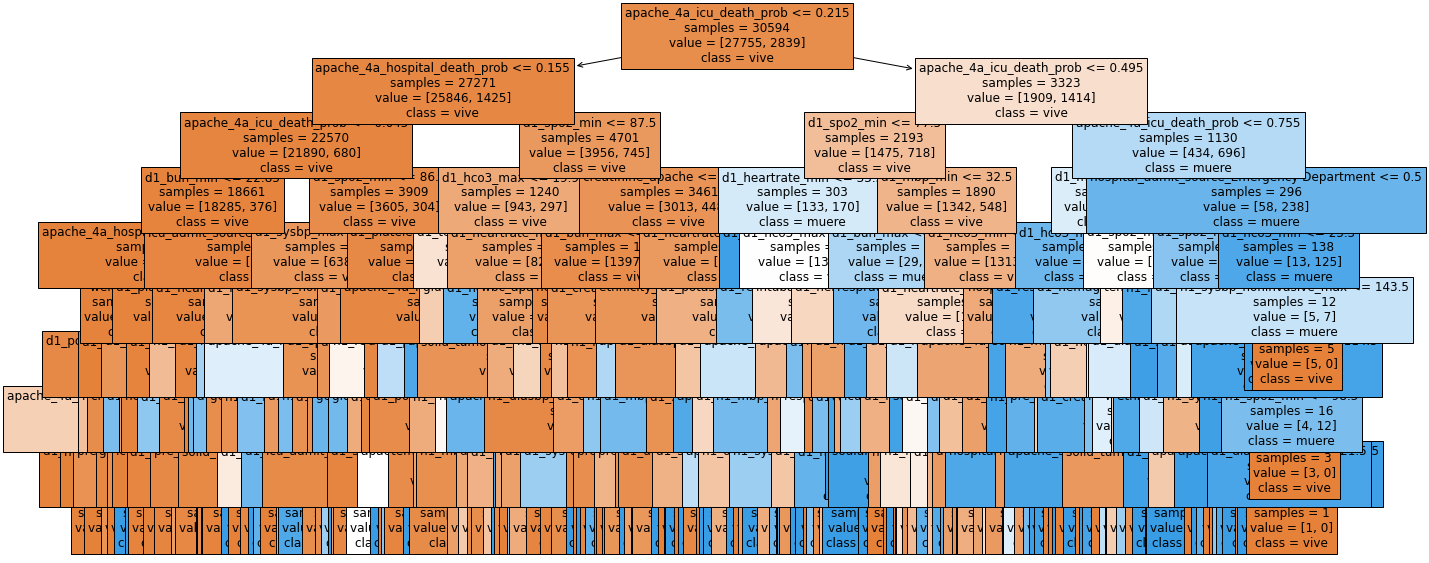

In [35]:
# Visualización de max_depth y nodos terminales
# ------------------------------------------------------------------------------
print(f'Profundidad del árbol: {modelo.get_depth()}')
print(f'Número de nodos terminales: {modelo.get_n_leaves()}')

# Grafica del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(70, 10))

plot = plot_tree(
            decision_tree = modelo,
            feature_names = f_df.columns.to_list(),
            class_names   = ('vive', 'muere'),
            filled        = True,
            impurity      = False,
            fontsize      = 12,
            ax            = ax,
       )

plt.tight_layout()
plt.show()

In [36]:
# Error de test del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test,)

print('Matriz de confusión')
print('-------------------')
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[11570,   305],
       [  897,   340]])

In [37]:
# Precisión del modelo inicial
#-------------------------------------------------------------------------------
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f'El accuracy de test es: {100 * accuracy} %')

El accuracy de test es: 90.83282489322758 %


### **Busqueda de hiperparámetros óptimos para el árbol**


Con la finalidad de buscar un modelo óptimo y realizar una poda de nuestro árbol inicial, realizaremos un Grid Search para algunos parámetros, y los estudiaremos por validación cruzada. 

Es importante recordar que, para que se guarde el modelo final de forma automática bajo `grid.best_params_`, debemos definir `refit = True`.

In [38]:
# Grid de parámetros evaluados
# ------------------------------------------------------------------------------
param_grid = {
              'max_depth'   : range(1,20),
              'max_features': ['sqrt', 'log2'],
              'ccp_alpha'   : [0, 0.25, 0.5, 1, 2]
         }

# Búsqueda por validación cruzada
# ------------------------------------------------------------------------------
grid = GridSearchCV(
        
        estimator = DecisionTreeClassifier(
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
      )

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': [0, 0.25, 0.5, 1, 2],
                         'max_depth': range(1, 20),
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy')

Una vez creado el modelo óptimo, revisamos cuales son los mejores parámetros encontrados.

In [39]:
# Mejores parámetros encontrados
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0, 'max_depth': 6, 'max_features': 'sqrt'}

Teniendo claros los datos, podemos visualizar la estructura del árbol del modelo final.

Profundidad del árbol: 6
Número de nodos terminales: 57


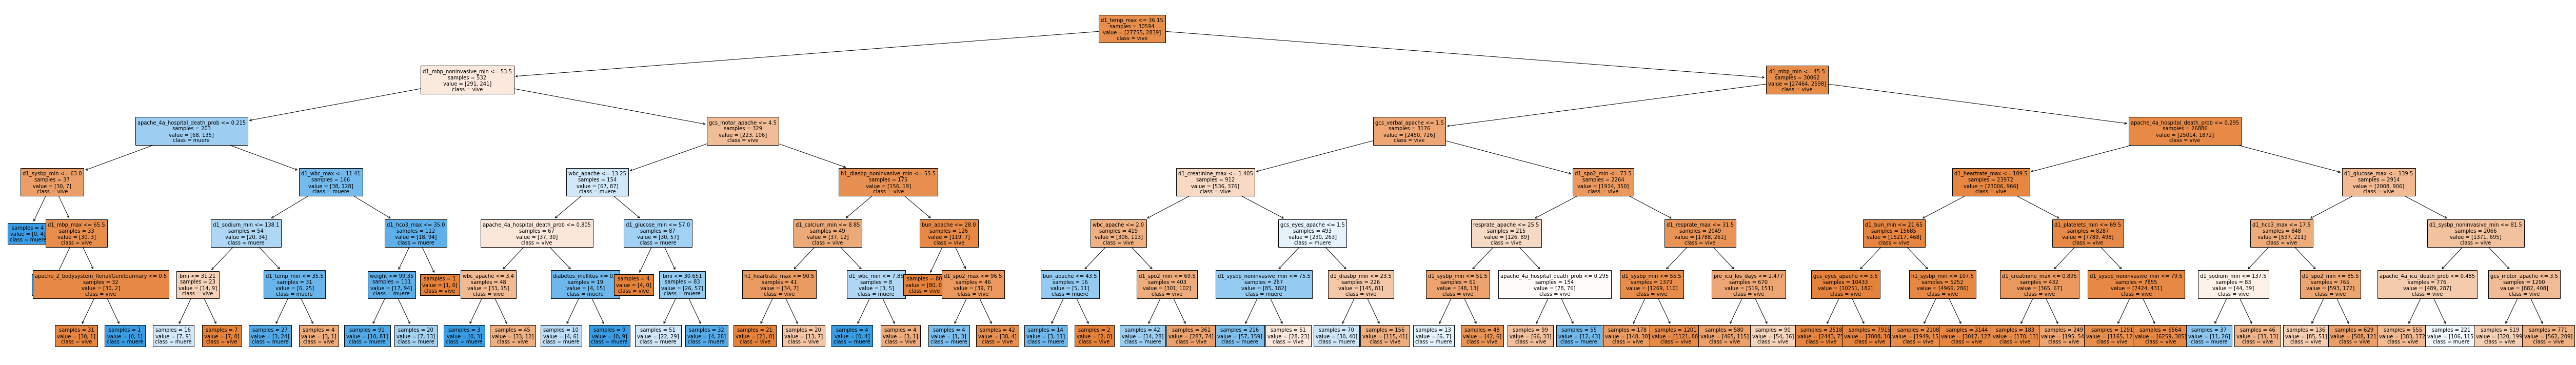

In [40]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_f = grid.best_estimator_
print(f'Profundidad del árbol: {modelo_f.get_depth()}')
print(f'Número de nodos terminales: {modelo_f.get_n_leaves()}')

# Grafica del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize = (70, 10))

plot = plot_tree(
            decision_tree = modelo_f,
            feature_names = f_df.columns.to_list(),
            class_names   = ('vive', 'muere'),
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            ax            = ax
       )

plt.tight_layout()
plt.show()


Con el árbol listo, procederemos a revisar el nivel de precisión del modelo final, para ser comparado el modelo inicial.

In [41]:
# Accuracy del modelo final
#-------------------------------------------------------------------------------
predicciones2 = modelo_f.predict(X = X_test)

accuracy2 = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones2,
            normalize = True
           )
print(f'El accuracy de test es: {100 * accuracy2} %')

El accuracy de test es: 91.39719341061623 %


Se observa que luego de la optimización de parámetros, se ha podido mejorar la precisión, pasando de un accuracy del 90.1% del modelo inicial, al del 91.4% del modelo final. Este es un excelenete número, pensando en que si esta precisión fuera más alta, deberíamos pensar en que hubo un sobreentrenamiento del modelo, y/o algún error en el proceso.

A continuación, revisemos la importancia de cada predictor usado para generar las predicciones del modelo final.

In [42]:
print('Importancia de los predictores en el modelo')
print('-------------------------------------------')
importancia_predictores = pd.DataFrame(
                            {'predictor': f_df.columns.tolist(),
                             'importancia': modelo_f.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
88                apache_4a_hospital_death_prob     0.357460
35                                   d1_mbp_min     0.121755
46                                  d1_temp_max     0.119167
17                            gcs_verbal_apache     0.073230
41                                  d1_spo2_min     0.047038
15                             gcs_motor_apache     0.035582
70                            d1_creatinine_max     0.030539
37                       d1_mbp_noninvasive_min     0.025030
14                              gcs_eyes_apache     0.022551
38                              d1_resprate_max     0.016217
45                     d1_sysbp_noninvasive_min     0.012833
89                     apache_4a_icu_death_prob     0.011875
43                                 d1_sysbp_min     0.010700
27                                   wbc_apache     0.010254
85                                d1_sodium_min     0.009999
74                                  d1_hco3_max     0.008832
32                             d1_heartrate_max     0.008420
67                                   d1_bun_min     0.008117
72                               d1_glucose_max     0.007822
29                                d1_diasbp_min     0.007806
81                             d1_platelets_min     0.006977
23                              resprate_apache     0.005827
2                                           bmi     0.005744
6                              pre_icu_los_days     0.005378
73                               d1_glucose_min     0.003053
12                                   bun_apache     0.002980
86                                   d1_wbc_max     0.002717
40                                  d1_spo2_max     0.002656
63                                 h1_sysbp_min     0.002627
47                                  d1_temp_min     0.002412
69                               d1_calcium_min     0.002343
51                    h1_diasbp_noninvasive_min     0.002146
52                             h1_heartrate_max     0.002129
87                                   d1_wbc_min     0.001908
7                                        weight     0.001604
145     apache_2_bodysystem_Renal/Genitourinary     0.001539
34                                   d1_mbp_max     0.001446
92                            diabetes_mellitus     0.001286
106  hospital_admit_source_Emergency Department     0.000000
107                 hospital_admit_source_Floor     0.000000
108                   hospital_admit_source_ICU     0.000000
109            hospital_admit_source_ICU to SDU     0.000000
110           hospital_admit_source_Observation     0.000000
139                 apache_3j_bodysystem_Sepsis     0.000000
103                                    gender_M     0.000000
105          hospital_admit_source_Direct Admit     0.000000
104     hospital_admit_source_Chest Pain Center     0.000000
112                 hospital_admit_source_Other     0.000000
102                     ethnicity_Other/Unknown     0.000000
101                   ethnicity_Native American     0.000000
100                          ethnicity_Hispanic     0.000000
99                          ethnicity_Caucasian     0.000000
98                              ethnicity_Asian     0.000000
97                  solid_tumor_with_metastasis     0.000000
96                                     lymphoma     0.000000
95                                     leukemia     0.000000
146             apache_2_bodysystem_Respiratory     0.000000
147                  apache_2_bodysystem_Trauma     0.000000
94                            immunosuppression     0.000000
111        hospital_admit_source_Operating Room     0.000000
118                      icu_admit_source_Floor     0.000000
113        hospital_admit_source_Other Hospital     0.000000
126                        icu_type_Cardiac ICU     0.000000
138            apache_3j_bodysystem_Respiratory     0.000000
137           apache_3j_bodysystem_Neurological     0.000000
136   apache

El principal predictor del modelo final es `apache_4a_hospital_death_prob`, que básicamente es la probabilidad de muerte que asigna el _**sistema Apache**_ en estadías hospitalarias, según las mediciones básicas que los equipos han recolectado y procesado por dicho sistema.

Como segundo y tercer predictores se encuentran `d1_mbp_min` y `d1_temp_max`, quienes representan el promedio más bajo de la presión sanguínea durante las primeras 24 horas en la unidad que se encuentra, y la temperatura más alta durante las primeras 24 horas en la unidad que se encuentra (medida de forma invasiva), respectivamente.

Éstos hallazgos son consecuentes con la información existente en la actualidad referente a medicina. Por ejemplo, el sistema Apache IV es muy utilizado para realizar predicciones de muerte previas a un ingreso en la unidad de cuidados intensivos. Para obtener su predicción, este sistema ya ha realizado un estudio probabilistico a los datos tales como presión, temperatura, albumia en sangre, hemogramas, entre otros. Dado lo anterior relatado, a modo muy personal, y considerando que es un sistema que se utiliza actualmente en hospitales, habría esperado una mayor implicancia del predictor, ya que por sí sólo debería ser un excelente indicador, puesto a que en hospitales sus equipos no realizarán un procesamiento de los datos como el realizado en este trabajo, principalmente por que sería imposible de realizar bajo las altas exigencias de tiempo y rendimiento en que se encuentra el personal.


### **Predicción de probabilidades**

Finalmente, revisaremos las probabilidades involucradas en cada predicción. Se debe tener en cuenta, como cada vez que se revisa esto, que estas probabilidades no serán necesariamente iguales unas con otras, por lo que no son representativas de todos las predicciones realizadas. Cada predicción es un mundo aparte, aunque se tenga un mismo resultado, como se verá a continuación.

Revisaremos un total de 20 probabilidades, ligadas a 20 predicciones.

In [43]:
# Predicción de probabilidades para 20 predicciones
#-------------------------------------------------------------------------------
predicciones_p = modelo_f.predict_proba(X = X_test)
predicciones_p[:20, :]

array([[0.97021446, 0.02978554],
       [0.93338884, 0.06661116],
       [0.95353443, 0.04646557],
       [0.97021446, 0.02978554],
       [0.92896175, 0.07103825],
       [0.61657033, 0.38342967],
       [0.92457306, 0.07542694],
       [0.9596056 , 0.0403944 ],
       [0.69009009, 0.30990991],
       [0.97021446, 0.02978554],
       [0.26388889, 0.73611111],
       [0.98648136, 0.01351864],
       [0.93338884, 0.06661116],
       [0.95353443, 0.04646557],
       [0.98648136, 0.01351864],
       [0.9596056 , 0.0403944 ],
       [0.95353443, 0.04646557],
       [0.93338884, 0.06661116],
       [0.93338884, 0.06661116],
       [0.98648136, 0.01351864]])

In [44]:
# Visualización final de predicciones y sus probabilidades por clase
# ------------------------------------------------------------------------------
predicciones_pf = pd.DataFrame(data=predicciones_p, columns=['Prob.vivir', 'Prob.morir'])
predicciones_pf['predicción'] = np.where(predicciones_pf['Prob.vivir'] > predicciones_pf['Prob.morir'],'vive', 'muere')
predicciones_pf.head(20)

Prob.vivir  Prob.morir predicción
0     0.970214    0.029786       vive
1     0.933389    0.066611       vive
2     0.953534    0.046466       vive
3     0.970214    0.029786       vive
4     0.928962    0.071038       vive
5     0.616570    0.383430       vive
6     0.924573    0.075427       vive
7     0.959606    0.040394       vive
8     0.690090    0.309910       vive
9     0.970214    0.029786       vive
10    0.263889    0.736111      muere
11    0.986481    0.013519       vive
12    0.933389    0.066611       vive
13    0.953534    0.046466       vive
14    0.986481    0.013519       vive
15    0.959606    0.040394       vive
16    0.953534    0.046466       vive
17    0.933389    0.066611       vive
18    0.933389    0.066611       vive
19    0.986481    0.013519       vive

Se puede apreciar que de los 20 casos predichos, sólo uno muere. Esta decisión fue tomada con una probabilidad del 0.74% de seguridad aproximadamente. Lo mismo se repite para cada una de las predicciones de quienes viven y sus respectivas probabilidades de vivir o de morir calculadas por el modelo.

📖
---

**Referencias**

- Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Libro.

- Árboles de desición con Python: Regresión y Clasificación by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at [_(Link)_](https://www.cienciadedatos.net/documentos/py08_random_forest_python.htmlhttps://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html) 

- Matplotlib 3.5.2 documentation [_(Link)_](https://matplotlib.org/stable/index.html)
- Scikit-learn.org/stable/modules/tree

- Scikit-learn.org/stable/modules/ensemble